In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from sklearn.metrics import roc_curve, auc
from torch.cuda.amp import autocast
from torch.utils.data import DataLoader
from tqdm import tqdm

from models.sfcn_original import SFCN

import sys
sys.path.append('..')
from utils.datasets import TorchDataset as TD

In [2]:
mode = 'test'
dataloader = DataLoader(TD(f'/data/Data/PD/{mode}'), batch_size=8, shuffle=False)

In [3]:
model = SFCN(output_dim=1, channel_number=[28, 58, 128, 256, 256, 64]).to('cuda')
checkpoint = torch.load('checkpoints/PD-SFCN/best_model.pt')
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [4]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))


def accuracy(y_true, y_pred, threshold=0.5):
    y_pred = y_pred > threshold
    return np.mean(y_pred == y_true)

In [5]:
@torch.no_grad()
def test(model, dataloader, device='cuda'):
    model.eval()

    pd_true = []
    pd_pred = []
    study = []
    sex = []
    scanner = []
    for batch in tqdm(dataloader, desc='Test'):
        x = batch[0].to(device)
        pd_true += batch[1].tolist()
        sex += batch[2].tolist()
        study += batch[3].tolist()
        scanner += batch[4].tolist()

        # Forward pass with mixed precision
        with autocast():
            pd_pred += model(x).detach().cpu().tolist()

    return pd_true, pd_pred, sex, study, scanner

In [6]:
pd_true, pd_pred, sex, study, scanner = test(model, dataloader)

Test: 100%|██████████| 42/42 [00:08<00:00,  4.71it/s]


In [7]:
pd_pred = sigmoid(np.array(pd_pred).flatten())
pd_true = np.array(pd_true).flatten()
acc = accuracy(pd_true, pd_pred)

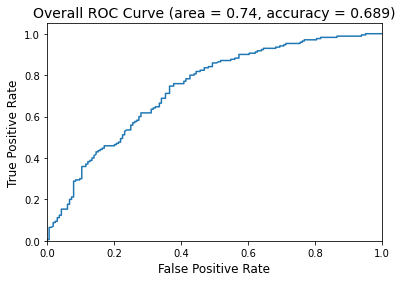

In [8]:
fpr, tpr, thresholds = roc_curve(pd_true, pd_pred)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label=f'Overall ROC curve (area = {roc_auc})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title(f'Overall ROC Curve (area = {round(roc_auc,2)}, accuracy = {round(acc,3)})', fontsize=14)
plt.savefig(f'/data/Papers/MICCAI-biases/subgroup-analysis/overall.pdf', dpi=300)

In [9]:
import pandas as pd

df = pd.DataFrame({'pd_true': pd_true, 'pd_pred': pd_pred, 'sex': sex, 'study': study, 'scanner': scanner})
df

,pd_true,pd_pred,sex,study,scanner
0,1,0.702224,1,3,2
1,0,0.349089,1,1,1
2,0,0.423220,1,0,0
3,0,0.682468,0,8,7
4,0,0.649134,1,6,5
...,...,...,...,...,...
329,1,0.871803,1,4,3
330,1,0.470144,0,5,4
331,0,0.651909,0,1,1
332,1,0.489099,1,8,7


In [10]:
def compute_scanner_roc(df, y_true_col='pd_true', y_prob_col='pd_pred',
                        subgroup_col='scanner'):
    unique_scanners = df[subgroup_col].unique()

    scanner_roc_metrics = {}
    accuracy = {}
    for scanner in unique_scanners:
        # Filter dataframe for current scanner
        scanner_df = df[df[subgroup_col] == scanner]

        # Extract true labels and probabilities
        y_true = scanner_df[y_true_col]
        y_prob = scanner_df[y_prob_col]
        acc = np.mean(y_true == (1 * y_prob > 0.5))
        accuracy[scanner] = acc

        print(f'Accuracy for {subgroup_col} {scanner}: {acc} ')

        try:
            # Compute ROC curve
            fpr, tpr, thresholds = roc_curve(y_true, y_prob)
            roc_auc = auc(fpr, tpr)

            # Store metrics
            scanner_roc_metrics[scanner] = {
                'fpr': fpr,
                'tpr': tpr,
                'thresholds': thresholds,
                'auc': roc_auc,
                'total_samples': len(scanner_df)
            }

        except ValueError as e:
            print(f"Error computing ROC for {subgroup_col} {scanner}: {e}")

    return scanner_roc_metrics, accuracy


def plot_scanner_roc_curves(df, y_true_col='y_true', y_prob_col='y_pred',
                            subgroup_col='scanner', figsize=(12, 6)):
    # Compute ROC metrics for each scanner
    scanner_roc_metrics, accuracy = compute_scanner_roc(
        df, y_true_col, y_prob_col, subgroup_col
    )

    fig, axs = plt.subplots(1, 2, figsize=figsize)
    colors = sns.color_palette('husl', len(scanner_roc_metrics))

    # Plot ROC for each scanner
    for (scanner, metrics), color in zip(scanner_roc_metrics.items(), colors):
        axs[0].plot(metrics['fpr'], metrics['tpr'],
                    label=f'{scanner} (AUC = {metrics["auc"]:.3f}, n={metrics["total_samples"]})',
                    color=color)

    # Plot random classifier line
    axs[0].plot([0, 1], [0, 1], 'k--', label='Random Classifier')

    # Customize plot
    axs[0].set_xlim([0.0, 1.0])
    axs[0].set_ylim([0.0, 1.05])
    axs[0].set_xlabel('False Positive Rate', fontsize=12)
    axs[0].set_ylabel('True Positive Rate', fontsize=12)
    axs[0].set_title(f'ROC Curves by {subgroup_col}', fontsize=14)
    axs[0].legend(loc="lower right", fontsize=10)
    axs[0].grid(True, linestyle='--', alpha=0.7)

    axs[1].bar(accuracy.keys(), accuracy.values(), color=colors)
    axs[1].set_xlabel(f'{subgroup_col}', fontsize=12)
    axs[1].set_ylabel('Accuracy (threshold=0.5)', fontsize=12)
    axs[1].set_title(f'Accuracy by {subgroup_col}', fontsize=14)

    plt.tight_layout()
    plt.savefig(f'/data/Papers/MICCAI-biases/subgroup-analysis/{subgroup_col}.pdf', dpi=300)
    plt.show()

    return scanner_roc_metrics


# Comprehensive analysis function
def comprehensive_scanner_performance(df, y_true_col='pd_true', y_prob_col='pd_pred',
                                      subgroup_col='scanner', thresholds=None):
    if thresholds is None:
        thresholds = np.linspace(0, 1, 100)

    # Compute ROC curves
    roc_metrics = plot_scanner_roc_curves(df, y_true_col, y_prob_col, subgroup_col)

    return roc_metrics

Accuracy for study 3: 0.8064516129032258 
Accuracy for study 1: 0.7346938775510204 
Accuracy for study 0: 0.6041666666666666 
Accuracy for study 8: 0.6216216216216216 
Accuracy for study 6: 0.6666666666666666 
Accuracy for study 2: 0.7391304347826086 
Accuracy for study 5: 0.6111111111111112 
Accuracy for study 7: 0.6666666666666666 
Accuracy for study 4: 0.5882352941176471 


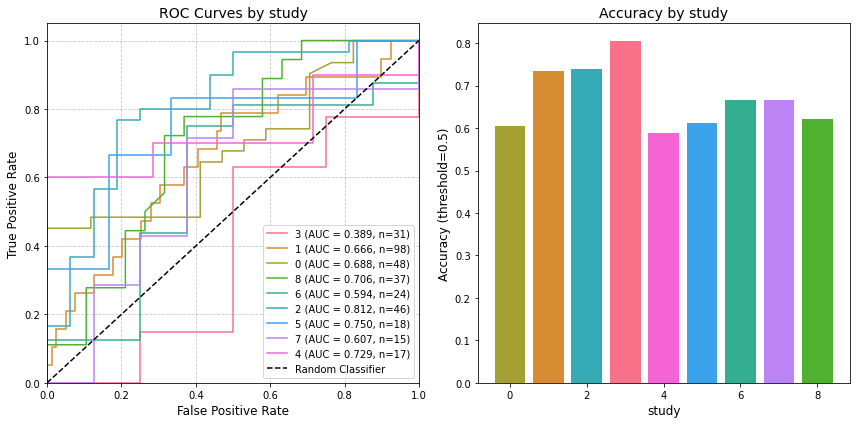

Accuracy for sex 1: 0.7357512953367875 
Accuracy for sex 0: 0.624113475177305 


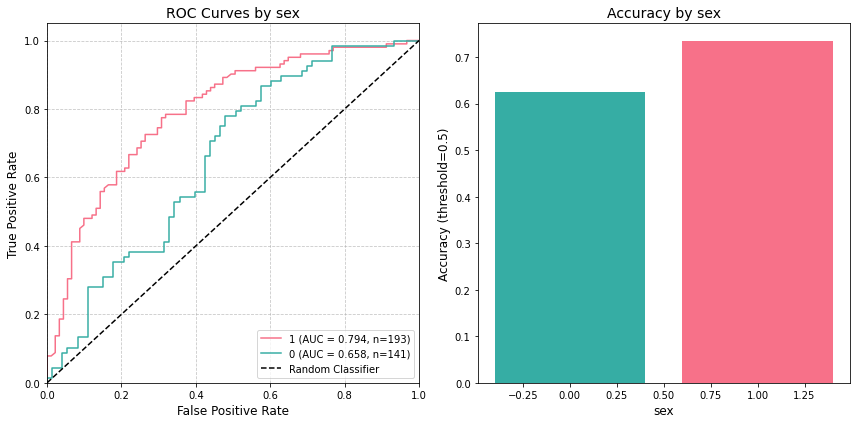

In [11]:
for sg in ['study', 'sex']:
    scanner_metrics = comprehensive_scanner_performance(df, subgroup_col=sg)